In [ ]:
#NOTE: This doesn't work, its actually worse than the previous version so there goes 15+ hours of work down the drain. Keeping it just because some of the code within it is good to have

import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
import torchvision.transforms as T
from utils.import_data import WiderFaceDataset, TRANSFORM, TRAIN_ROOT, TRAIN_ANN_FILE, VAL_ROOT, VAL_ANN_FILE
#from utils.anchors import AnchorMatcher, AnchorGenerator, box_nms, compute_loss_with_anchors
from utils.anchors import box_nms
from utils.simpleLoss import compute_loss

from PIL import Image



#custom collate function to seperate the boxes from the images
def custom_collate_fn(batch):
    images, targets = zip(*batch)  # unzip the batch
    return images, targets

# Create the dataset
dataset = WiderFaceDataset(
    root_dir=TRAIN_ROOT, 
    annotation_file=TRAIN_ANN_FILE, 
    img_size=224, 
    transform=TRANSFORM,
    single_face_only=True #if true, thirds the total images
    )

# Create a dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=64, #64 runs quickest on desktop
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    #use collate here because our data has the images but also the boxes and number of boxes
    collate_fn = custom_collate_fn
    )


#load validation pictures
val_dataset = WiderFaceDataset(
    root_dir=VAL_ROOT, 
    annotation_file=VAL_ANN_FILE, 
    img_size=224, 
    transform=TRANSFORM,
    single_face_only=True
    )

val_loader = DataLoader(
    val_dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn = custom_collate_fn
    )

print(f"Total train images: {len(dataset)}")
print(f"Total validation images: {len(val_dataset)}")


Total train images: 4631
Total validation images: 1122


In [2]:
#validation function that returns the loss and confidence for the validation set
def validate(model, val_loader, device):
    model.eval()
    val_loss = 0.0
    total_conf = 0.0
    count = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = torch.stack(images).to(device)
            outputs = model(images)

            loss = compute_loss(outputs, targets)
            val_loss += loss.item()


            confs = torch.sigmoid(outputs[:, 4])  # confidence logits → probs
            
            total_conf += confs.sum().item()
            count += confs.numel()
    
    loss = val_loss / len(val_loader)
    conf = total_conf / max(count, 1)
    model.train() #set net back to training
    return loss, conf



def compute_iou(box1, box2):
    """
    Compute IoU for single boxes.
    box1, box2: 1D tensors [x1, y1, x2, y2]
    Returns: IoU scalar
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter_area = inter_w * inter_h

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter_area + 1e-6

    return inter_area / union

def validate_iou(net, val_loader, device, img_size=224):
    """
    IoU validation for single-face detector without anchors.
    net: FaceDetectionNet (outputs [B,5] per image: x1,y1,x2,y2,conf)
    val_loader: DataLoader for validation
    """
    net.eval()
    iou_sum = 0.0
    count = 0

    for images, targets in val_loader:
        images = torch.stack(images).to(device)  # [B,3,H,W]
        outputs = net(images)                    # [B,5]

        for i in range(len(images)):
            pred = outputs[i]            # [5]
            pred_box = pred[:4] * img_size
            pred_score = torch.sigmoid(pred[4])

            gt_boxes = targets[i]['boxes']
            if gt_boxes.shape[0] == 0:
                continue

            gt_box = gt_boxes[0]        # single-face assumption
            iou_sum += compute_iou(pred_box.detach().cpu(), gt_box.detach().cpu())
            count += 1

    net.train()
    return iou_sum / max(count,1)

#Computes the intersection over union (IoU) for a single face image. On a scale of 0-1, a higher number means the boxes are more accurate
def anchor_validate_iou(net, val_loader, device, conf_thresh=0.5, nms_thresh=0.4, img_size=224):
    """
    Compute average IoU (Intersection over Union) on the validation set for a single-face detector.

    net: trained FaceDetectionNet
    val_loader: DataLoader for validation set
    device: 'cuda' or 'cpu'
    conf_thresh: confidence threshold to filter predictions
    nms_thresh: IoU threshold for non-max suppression
    img_size: size images were resized to during training
    """
    net.eval()
    iou_sum = 0.0
    count = 0

    with torch.no_grad():
        for images, targets in val_loader:
            # Stack images and move to device
            images = torch.stack(images).to(device)
            outputs = net(images)  # [B, num_anchors, 5, H, W]

            B = len(images)
            for i in range(B):
                pred = outputs[i]  # [num_anchors, 5, H, W]

                # Flatten spatial dims
                num_anchors, C, H, W = pred.shape
                pred_flat = pred.view(num_anchors, C, -1).permute(2, 0, 1).reshape(-1, 5)

                # Separate boxes and confidence
                pred_boxes = pred_flat[:, :4] * img_size       # rescale
                pred_scores = torch.sigmoid(pred_flat[:, 4])

                # Apply confidence threshold
                keep = pred_scores > conf_thresh
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                # Apply NMS if we have predictions
                if pred_boxes.shape[0] > 0:
                    keep_idx = box_nms(pred_boxes, pred_scores, iou_threshold=nms_thresh)
                    pred_boxes = pred_boxes[keep_idx]
                    pred_scores = pred_scores[keep_idx]

                    # Take top-scoring box (single-face net)
                    top_idx = pred_scores.argmax()
                    pred_box = pred_boxes[top_idx]

                    # Get GT box (assumes single face)
                    gt_boxes = targets[i]['boxes']
                    if gt_boxes.shape[0] == 0:
                        continue
                    gt_box = gt_boxes[0]

                    # Compute IoU
                    iou_sum += compute_iou(pred_box.detach().cpu(), gt_box.detach().cpu())
                    count += 1

    net.train()
    return iou_sum / max(count, 1)

In [3]:
class FaceDetectionNet(nn.Module):
    def __init__(self, num_anchors=1):
        """
        num_anchors: number of boxes predicted per spatial cell (simplest: 1)
        kernel_size is the size of the box we pass over each img to extract the features, exactly like tf (3,3,3)
        """
        super(FaceDetectionNet, self).__init__()

        #Backbone: feature extractor
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # RGB input
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample by 2 -> 112x1112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample by 2 -> 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample by 2 -> 28x28

            nn.Conv2d(256,512,3,padding=1), 
            nn.BatchNorm2d(512),
             nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Detection head
        # Predict bounding boxes + confidence
        # Output channels = num_anchors * 5 (x, y, w, h, conf)
        #self.det_head = nn.Conv2d(256, num_anchors * 5, kernel_size=1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
        )


    def forward(self, x): #defines the computation performed every iteration
        x = self.backbone(x)
        x = self.gap(x).flatten(1)
        return self.head(x)
    # def forward(self, x):
    #     """
    #     x: [batch_size, 3, H, W]
    #     Returns:
    #         out: [batch_size, num_anchors * 5, H/4, W/4] 
    #              Each cell predicts (x, y, w, h, confidence)
    #     """
    #     features = self.backbone(x)
    #     out = self.det_head(features)  # [B, 5*num_anchors, H', W']

    #     B, C, H, W = out.shape
    #     out = out.view(B, -1, 5, H, W)  # [B, num_anchors, 5, H', W']
    #     return out

In [12]:
#Training Loop
start_epoch = 0
num_epochs = 30
loadLastCheckpoint = False
checkpoint_rate = 10
validationRate = 10 #validation adds about ~1 minute   so dont run frequently
net = FaceDetectionNet()


#moves all the info to the gpu (cuda) if it can, if not it keeps it on the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}") 
net = net.to(device)


optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
scaler = GradScaler()


if loadLastCheckpoint:
    # Check for existing checkpoints and load the latest one
    checkpoint_files = [f for f in os.listdir("checkpoints") if f.startswith("faceNet_checkpoint")]
    if checkpoint_files:
        # Sort by epoch number and get the latest
        latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split('checkpoint')[1].split('.')[0]))[-1]
        checkpoint_path = os.path.join("checkpoints", latest_checkpoint)
        
        checkpoint = torch.load(checkpoint_path, map_location=device)
        net.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"Loaded checkpoint from epoch {checkpoint['epoch'] + 1}")

timer_start = time.time()
for epoch in range(start_epoch, num_epochs):
    net.train() # sets the net to training mode
    epoch_loss = 0

    #with pytorch it wont let you pass the entire dataset to the net at once so you have to send it in batches (thats what the batch size is for)
    for images, targets in dataloader:
        # images is a tuple of tensors; stack into a single batch tensor
        images = torch.stack(images).to(device)    # shape: [batch_size, 3, 224, 224]
        boxes = [t['boxes'].to(device) for t in targets]  # move each image's boxes to GPU

        optimizer.zero_grad()               # resets gradients

        #autocast lets you use mixed precision for faster training on nvidia gpu, uses 16bit floating points instead of 32
        with autocast('cuda'):                  #use FP16 for forward pass
            outputs = net(images)               #forward pass
            #loss = compute_loss_with_anchors(outputs, boxes, anchors, matcher, device)
            loss = compute_loss(outputs, targets)
             
        scaler.scale(loss).backward()           #backpropogation
        scaler.step(optimizer)                  #update weights
        scaler.update()
        
        epoch_loss += loss.item()  # accumulate batch loss


    #timer to see how long each epoch takes
    timer_end = time.time()
    length = timer_end-timer_start
    mins, secs = divmod(length, 60)
    

    avg_epoch_loss = epoch_loss / len(dataloader)
    

    if (epoch+1) % validationRate == 0:
        val_loss, val_conf = validate(net, val_loader, device)
        avg_iou = validate_iou(net, val_loader, device)

        torch.cuda.empty_cache() #free up the cache on the gpu after checking iou
        
        print(
        f"Epoch [{epoch+1}/{num_epochs}]"
        f" - Train Loss: {avg_epoch_loss:.4f}"
        f" - Val IoU: {avg_iou:.4f}"
        f" - Val Loss: {val_loss:.4f}"
        f" - Val Conf: {val_conf*100:.2f}%"
        f" - Time taken: 0{int(mins)}:{secs:.2f}"
        )
    else:
        print(
            f"Epoch [{epoch+1}/{num_epochs}]"
            f" - Train Loss: {avg_epoch_loss:.4f}"
            f" - Time taken: 0{int(mins)}:{secs:.2f}"
        )

    timer_start = time.time() #reset timer
    
    #saves a checkpoint
    if (epoch+1) % checkpoint_rate == 0:
        torch.save({
            "epoch": epoch,
            "model_state": net.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "loss": avg_epoch_loss
        }, f"checkpoints/faceNet_checkpoint{epoch+1}.pth")


Training on: cuda
Epoch [1/30] - Train Loss: 0.0527 - Time taken: 00:51.66
Epoch [2/30] - Train Loss: 0.0119 - Time taken: 00:51.30
Epoch [3/30] - Train Loss: 0.0114 - Time taken: 00:51.21
Epoch [4/30] - Train Loss: 0.0110 - Time taken: 00:51.12
Epoch [5/30] - Train Loss: 0.0110 - Time taken: 00:51.86
Epoch [6/30] - Train Loss: 0.0105 - Time taken: 00:55.03
Epoch [7/30] - Train Loss: 0.0104 - Time taken: 00:55.02
Epoch [8/30] - Train Loss: 0.0103 - Time taken: 00:55.17
Epoch [9/30] - Train Loss: 0.0106 - Time taken: 00:55.03
Epoch [10/30] - Train Loss: 0.0107 - Val IoU: 0.1932 - Val Loss: 0.0108 - Val Conf: 99.99% - Time taken: 00:54.98
Epoch [11/30] - Train Loss: 0.0099 - Time taken: 00:54.90
Epoch [12/30] - Train Loss: 0.0100 - Time taken: 00:54.90
Epoch [13/30] - Train Loss: 0.0101 - Time taken: 00:53.27
Epoch [14/30] - Train Loss: 0.0094 - Time taken: 00:50.76
Epoch [15/30] - Train Loss: 0.0094 - Time taken: 00:50.87
Epoch [16/30] - Train Loss: 0.0093 - Time taken: 00:50.87
Epoch [

In [ ]:
#Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loadedNet = FaceDetectionNet1()
checkpoint_path = os.path.join("checkpoints", "faceNet_checkpoint100.pth")
checkpoint = torch.load(checkpoint_path, map_location=device)
loadedNet.load_state_dict(checkpoint["model_state"])
loadedNet.to(device)

#VERY IMPORTANT for inference - Sets the net to evaluation mode
loadedNet.eval()

In [8]:
#function to test a single image


#test net without anchors
def simple_test_net(img_path, test_net, conf_thresh=0.5):
    image = Image.open(img_path).convert("RGB")
    orig_w, orig_h = image.size

    x = TRANSFORM(image).unsqueeze(0).to(device)

    with torch.no_grad():
        #out = net(x)
        out = test_net(x)
        
    box = out[0, :4] * 224.0
    conf = torch.sigmoid(out[0, 4])

    if conf < conf_thresh:
        return None, None

    # scale back
    box[0::2] *= orig_w / 224
    box[1::2] *= orig_h / 224

    return box.cpu(), conf.cpu()


def anchor_test_net(img_path, test_net):
    #load image w/ preprocessing
    image = Image.open(img_path).convert("RGB")
    
    orig_w, orig_h = image.size  # save original size

    image_tensor = TRANSFORM(image)   # same TRANSFORM as training
    image_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 3, 224, 224]

    #forward pass w/ no gradient
    with torch.no_grad():
        outputs = test_net(image_tensor)

    #decode the predicitions into boxes and scores
    pred = outputs[0]  # [1, 5, 28, 28]

    # Flatten
    pred = pred.view(5, -1).permute(1, 0)  # [28*28, 5]

    pred_boxes = pred[:, :4] * 224.0   # undo normalization
    pred_scores = torch.sigmoid(pred[:, 4])

    #apply confidence threshhold and nms (non max suppresion)
    CONF_THRESH = 0.5
    NMS_THRESH = 0.4

    keep = pred_scores > CONF_THRESH
    pred_boxes = pred_boxes[keep]
    pred_scores = pred_scores[keep]

    if pred_boxes.shape[0] > 0:
        keep_idx = box_nms(pred_boxes, pred_scores, iou_threshold=NMS_THRESH)
        pred_boxes = pred_boxes[keep_idx]
        pred_scores = pred_scores[keep_idx]


    #scale boxes back into original image
    scale_x = orig_w / 224
    scale_y = orig_h / 224

    pred_boxes[:, [0, 2]] *= scale_x
    pred_boxes[:, [1, 3]] *= scale_y

    return pred_boxes, pred_scores

In [13]:
IMG_PATH = r"C:\Code\Neural Net Projects\FaceNet\Dataset\WIDER_test\images\31--Waiter_Waitress\31_Waiter_Waitress_Waiter_Waitress_31_99.jpg"

Avg iou: 0.13385538756847382


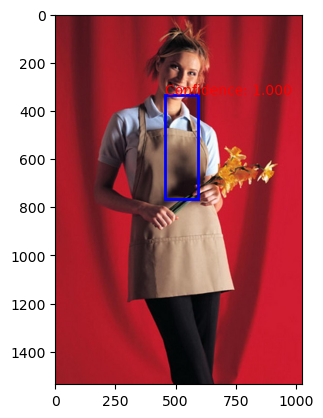

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net = FaceDetectionNet()
checkpoint_path = os.path.join("checkpoints", "faceNet_checkpoint40.pth")
checkpoint = torch.load(checkpoint_path, map_location=device)
net.load_state_dict(checkpoint["model_state"])
# net.to(device)
# net.eval()
avg_iou = validate_iou(net, val_loader, device)
print(f"Avg iou: {avg_iou}")

image = Image.open(IMG_PATH).convert("RGB")
box, score = simple_test_net(IMG_PATH, net)
fig, ax = plt.subplots(1)
ax.imshow(image)

if box is not None:
    x1, y1, x2, y2 = box.squeeze(0).detach().cpu().tolist()

    rect = patches.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(rect)

    ax.text(
        x1,
        y1 - 5,
        f"Confidence: {score.item():.3f}",
        color='red'
    )
else:
    ax.text(
        10, 20,
        "No face detected",
        color='red',
        fontsize=12
    )

plt.show()

tensor(0.2095)


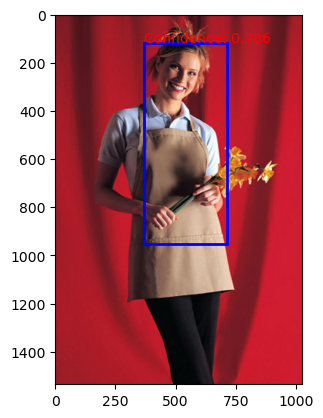

In [15]:
from utils.model import FaceDetectionNet1 #temp just to check old model
#Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loadedNet = FaceDetectionNet1()
checkpoint_path = os.path.join("checkpoints", "faceNet_checkpoint100.pth")
checkpoint = torch.load(checkpoint_path, map_location=device)
loadedNet.load_state_dict(checkpoint["model_state"])
loadedNet.to(device)
loadedNet.eval()


#Works with the old net model that used anchors, since moving to only detect one face the test function changed
import matplotlib.pyplot as plt
import matplotlib.patches as patches


avg_iou = anchor_validate_iou(loadedNet, val_loader, device)
print(avg_iou)
pred_boxes, pred_scores = anchor_test_net(IMG_PATH, loadedNet)


image = Image.open(IMG_PATH).convert("RGB")
fig, ax = plt.subplots(1)
ax.imshow(image)

for box, score in zip(pred_boxes, pred_scores):
    x1, y1, x2, y2 = box.cpu()
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='blue', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"Confidence: {score:.3f}", color='red')

plt.show()